# Petfinder.my adoption competition: feature engineering, part one

## Introduction

As the clunky title suggests, this notebook contains the first part of the feature engineering for the petfinder.my Kaggle competition. As well as deriving new features, I also look here at the image and semantic information provided in the official competition data sets.

## Libraries

In [1]:
import os, json

import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

## Function definitions

In [2]:
def train_test_catplot(var_name:str):
    """
    Plots sns.catplot() for a variable in both the training and test datasets
    """
    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    g = sns.catplot(x=var_name, data=all_train, kind='count', ax=ax[0])
    ax[0].set_title('Train')
    plt.close(g.fig)
    g = sns.catplot(x=var_name, data=all_test, kind='count', ax=ax[1])
    ax[1].set_title('Test')
    plt.close(g.fig)
    plt.show()

In [3]:
def speed_catplot(var_name:str, title1:str, title2:str):
    """
    Plots both within and between-variable sns.catplot() for AdoptionSpeed
    """
    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    g = sns.catplot(x=var_name, hue='AdoptionSpeed', data=all_train, kind='count', ax=ax[0])
    ax[0].set_title(title1)
    plt.close(g.fig)
    g = sns.catplot(x='AdoptionSpeed', hue=var_name, data=all_train, kind='count', ax=ax[1])
    ax[1].set_title(title2)
    plt.close(g.fig)
    plt.show()

In [4]:
def train_test_distplot(var_name:str):
    """
    Plots sns.distplot() for a continuous variable in both the training and test datasets
    """
    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.distplot(all_train[var_name], kde=False, ax=ax[0])
    ax[0].set_title('Train')
    sns.distplot(all_test[var_name], kde=False, ax=ax[1])
    ax[1].set_title('Test')
    plt.show()

In [5]:
def speed_stripplot(var_name: str):
    plt.figure(figsize=(12, 5))
    sns.stripplot(x='AdoptionSpeed', y=var_name, data=all_train)
    plt.title(f'{var_name} by adoption speed')
    plt.show()

## Data loading

In [6]:
INPUT_PATH = os.path.join(os.pardir, 'data', 'raw')

In [7]:
!ls {INPUT_PATH}

breed_labels.csv       test.csv		   train.csv
color_labels.csv       test_images.zip	   train_images.zip
sample_submission.csv  test_metadata.zip   train_metadata.zip
sentiment	       test_sentiment.zip  train_sentiment.zip
state_labels.csv       test.zip		   train.zip


In [8]:
all_train = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
all_test = pd.read_csv(os.path.join(INPUT_PATH, 'test.csv'))

In [9]:
# New features must be added to both the training and testing data
# Both are combined into a list to be iterated over
all_data = [all_train, all_test]

## Pet name

The `Name` feature, as expected, contains the name of the pet in the adoption listing. This is typically left blank when the pet is unnamed, although some entries contain strings like 'No Name' instead.

Whether a pet is named may have some impact on adoption speed and so I created a new feature `IsNamed` where 0 = Unnamed and 1 = Named.

In [10]:
for df in all_data:
    df['IsNamed'] = np.where(
        (df['Name'].isna()) |
        (df['Name'] == 'No Name') |
        (df['Name'] == 'No Name Yet'), 0, 1
    )

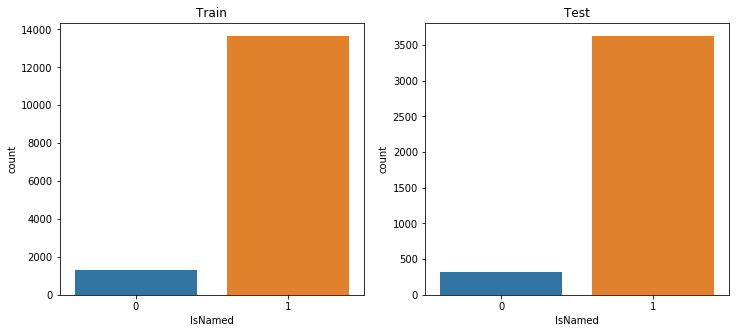

In [11]:
train_test_catplot('IsNamed')

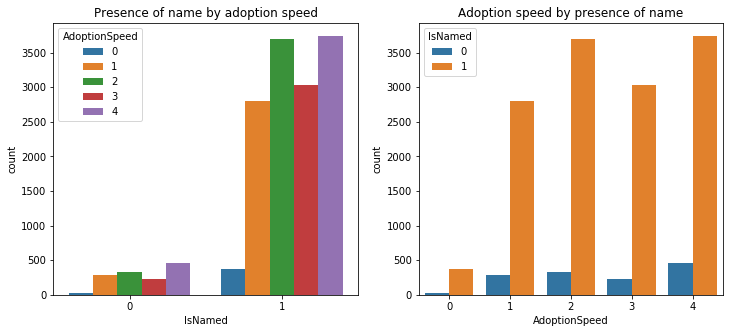

In [12]:
speed_catplot('IsNamed', 'Presence of name by adoption speed', 'Adoption speed by presence of name')

Pets without a name are less likely to be adopted the same day as listing compared to those with names. There appears to also be a slightly larger number of unnamed pets in category 4 than any of the quicker adoption speed categories.

## Pet descriptions

The majority of pet listings include a short description of some relevant aspect of the animal and why it is being listed for adoption. Not all pets have a description, and, as with `Name` earlier, the presence or lack of a description might affect adoption speed.

In [13]:
for df in all_data:
    print(df['Description'].isna().sum())

12
2


Only 12 descriptions in the training data and 2 in the testing data are missing. A new feature, `HasDescription` was created where 0 = No description and 1 = Has description.

In [14]:
for df in all_data:
    df['HasDescription'] = np.where(df['Description'].isna(), 0, 1)

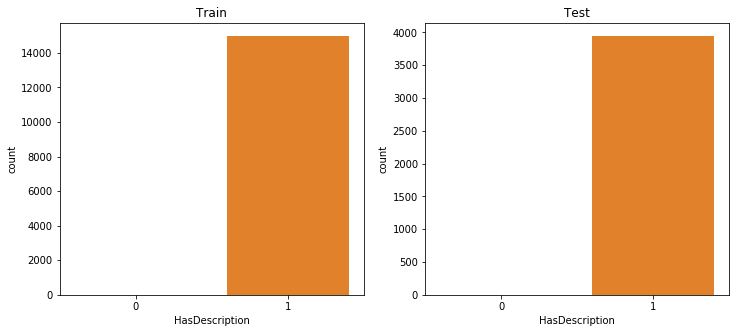

In [15]:
train_test_catplot('HasDescription')

There are too few listings without a description to even show up on the count plot...

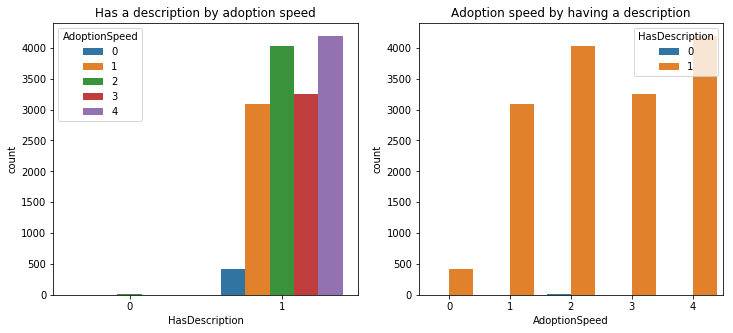

In [16]:
speed_catplot('HasDescription', 'Has a description by adoption speed', 'Adoption speed by having a description')

The number of listings without a description is far too small to be interpretable. It will, however, be retained until initial modelling where its importance can be properly examined.

### Description sentiment

The competition organisers ran the pet descriptions through Google's Natural Language API to provide sentiment information. This is included in JSON format in the `train_sentiment` and `test_sentiment` archives. It was not possible to calculate sentiment for every description and so there are missing values.

Of the sentiment information given, two results are used here in the creation of new features: document sentiment score and sentiment magnitude. The former is the overall sentiment score (normalised between -1 and +1), in which positive values indicate a positive sentiment, negative values a negative sentiment and 0 a neutral sentiment. The latter (between 0 and +inf) indicates the overall strength of sentiments, both positive and negative. The smaller the value, the more neutral the document emotion, whereas higher values are associated with greater emotion.

In [17]:
def get_sentiment(df: pd.DataFrame, train_test: str)->pd.DataFrame:
    sentiments = {'PetID': [], 'SentScore': [], 'SentMagnitude': []}
    
    PATH = os.path.join(INPUT_PATH, 'sentiment', train_test)
    
    for f in os.listdir(PATH):
        with open(os.path.join(PATH, f), 'r') as jfile:
            sentiment_doc = json.load(jfile)
            sentiments['SentScore'].append(sentiment_doc['documentSentiment']['score'])
            sentiments['SentMagnitude'].append(sentiment_doc['documentSentiment']['magnitude'])
            sentiments['PetID'].append(f.split('.')[0])
            jfile.close()
    sentiment_df = pd.DataFrame(sentiments)
    
    return df.join(sentiment_df.set_index('PetID'), on='PetID')

In [18]:
all_train = get_sentiment(all_train, 'train')

In [19]:
all_test = get_sentiment(all_test, 'test')

In [20]:
# The df list needs to be remade
all_data = [all_train, all_test]

In [21]:
# Replace NA values with 0 for both Score and Magnitude
# Perhaps a separate placeholder value (e.g. -2) would be better?
for df in all_data:
    df['SentScore'].fillna(0, inplace=True)
    df['SentMagnitude'].fillna(0, inplace=True)

#### Sentiment score

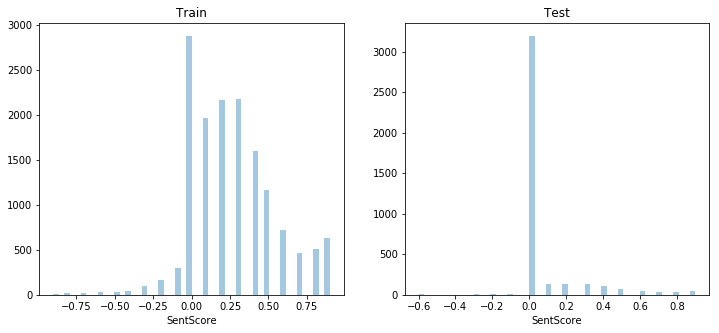

In [22]:
train_test_distplot('SentScore')

The testing data has considerably less variation in description sentiment score than the training data. In both cases, however, most descriptions are positive overall.

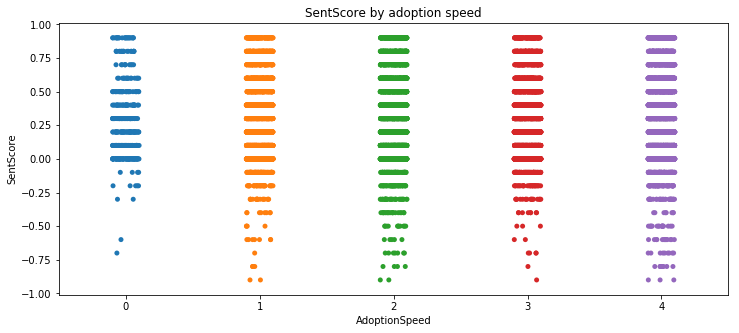

In [23]:
speed_stripplot('SentScore')

Pets that are adopted the slowest (4) appear to have descriptions with lower sentiment scores overall than other categories, although the overall relationship between sentiment score and adoption speed seems weak.

#### Sentiment Magnitude

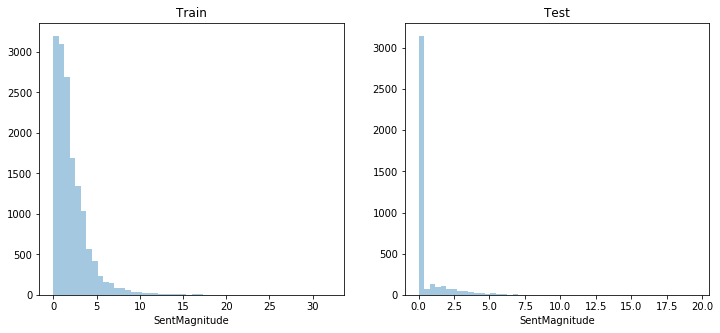

In [24]:
train_test_distplot('SentMagnitude')

As expected from the document sentiment score, the distributions of sentiment magnitudes differ greatly between both datasets.

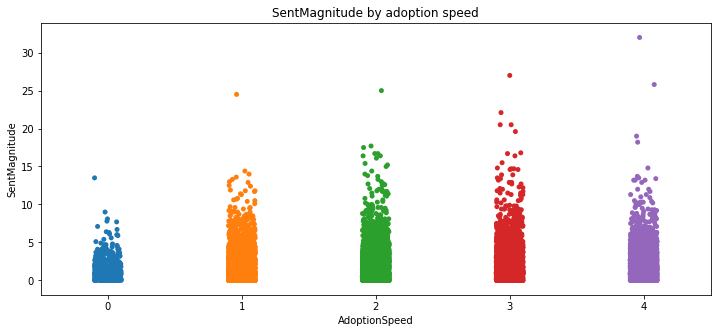

In [25]:
speed_stripplot('SentMagnitude')

### Description length

The length of a description (here measured in words, although e.g. sentences is a possible alternative) may affect adoption speed.

In [26]:
for df in all_data:
    df['DescWords'] = df['Description'].apply(lambda x: len(str(x).split()))
    df['DescWords'].fillna(0, inplace=True)

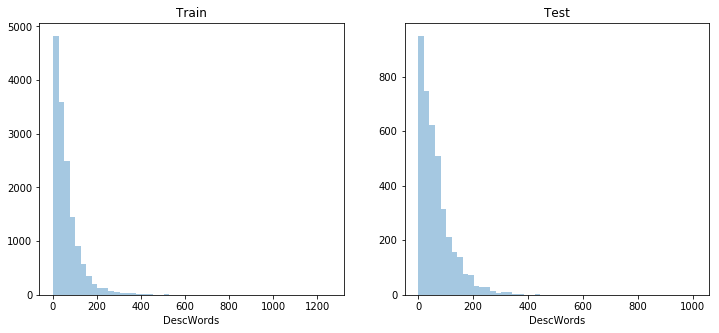

In [27]:
train_test_distplot('DescWords')

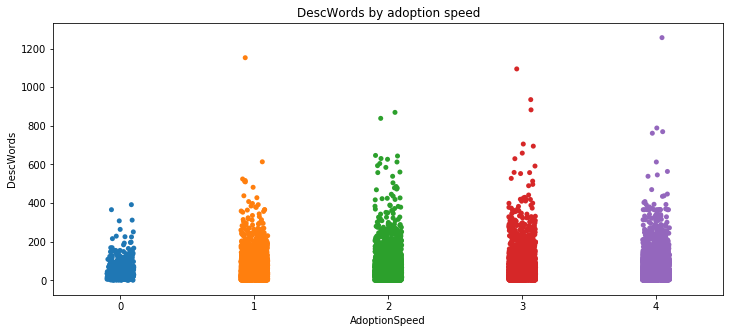

In [28]:
speed_stripplot('DescWords')

### Latent Semantic Analysis (LSA)

LSA is an approach to topic modelling. It consists of two parts: first, TF-IDF vectors are computed for the documents, then second, Singular Value Decomposition (SVD) is used for dimensionality reduction of the TF-IDF vectors. In short, LSA, compared to TF-IDF, results in a smaller, and ideally better, set of topic features.

In [29]:
# Get descriptions and replace na values with 'none'
train_desc = all_train['Description'].fillna("none")
test_desc = all_test['Description'].fillna("none")

In [39]:
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 3),
                       stop_words='english', strip_accents='unicode',
                       min_df=3, max_df=0.9, max_features=5000,
                       use_idf=True, smooth_idf=True, sublinear_tf=True, norm='l2')

svd_components = 300
svd = TruncatedSVD(n_components=svd_components)

In [34]:
# Create TF-IDF vectors for training and testing data
tfidf.fit(list(train_desc))

train_tfidf = tfidf.transform(train_desc)
test_tfidf = tfidf.transform(test_desc)

In [38]:
# Create SVD vectors from TF-IDF input
svd.fit(train_tfidf)

train_svd = svd.transform(train_tfidf)
test_svd = svd.transform(test_tfidf)

In [42]:
# Combine data
train_svd = pd.DataFrame(train_svd, columns=[f"svd_{i}" for i in range(svd_components)])
test_svd = pd.DataFrame(test_svd, columns=[f"svd_{i}" for i in range(svd_components)])

all_train = pd.concat((all_train, train_svd), axis=1)
all_test = pd.concat((all_test, test_svd), axis=1)

## Pet images

Included along with the tabular and JSON sentiment data are images of each pet uploaded with the adoption listing. At present I have not examined these images directly. The competition organisers ran all the images through Google Cloud Vision and included the results (`train_metadata.zip` and `test_metadata.zip`).

(The initial version of this code will probably be a mess. Apoligies in advance!)